In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) 
# that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [105]:
# фиксируем RANDOM_SEED для воспроизводимости
RANDOM_SEED = 34

In [106]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # сабмишн

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [108]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [110]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [111]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [112]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [113]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score заполняем нулями

# объединяем
data = pd.concat([df_test, df_train], axis=0, ignore_index=True)

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Для корректной работы модели преобразуем пропущенные данные
* Пропущенные данные встречаются в столбцах геопозиции. Заменяем пропуски нулем.

In [115]:

data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

### Преобразование признаков
* Преобразуем review_date в формат даты
* Сoздадим новый признак review_days с количеством дней, за точку осчета возьмем максимальную дату в датасете. Получится количетсво прошедших дней с даты последнего отзыва.
* Создадим новый признак review_month - месяц, в котором составлен отзыв
* days_since_review преобразуем в числовой формат
* Первоначальный review_date удалим

In [116]:
data['review_date'] = pd.to_datetime(data.review_date, format='%m/%d/%Y')
display(f"Максимальная дата (дата последнего отзыва): {data['review_date'].max():%Y-%m-%d}")
data['review_days'] = (pd.to_datetime(data['review_date'].max()) - data['review_date']).dt.days

data['review_month'] = data['review_date'].dt.month
data['days_since_review'] = pd.to_timedelta(data['days_since_review']).dt.days

data.drop(columns='review_date', inplace=True)

'Максимальная дата (дата последнего отзыва): 2017-08-03'

#### Преобразуем столбец tags
* Для получения списка тегов в виде list oбрезаем пробелы и символы []" в начале и в конце значений столбца
* Создаем лист используя разделитель " ,"
* У каждого тега внутри листа обрезаем пробелы и символы ' "
* Создаем новый признак tags_count с количиством тегов

In [117]:
data['tags'] = data['tags'].str.strip('" []').str.split(", ").apply(lambda x: [tag.strip('\"\' ') for tag in x])
display(data['tags'].explode().value_counts().head(10))
data['tags_count'] = data['tags'].apply(len)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: tags, dtype: int64

* Для десяти самых популярных тегов создадим отдельные признаки

In [118]:
popular_tegs = data['tags'].explode().value_counts().nlargest(10).index.to_list()
popular_tegs

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children']

In [119]:
def tags_columns(df):
    for new_col in popular_tegs:
        df[new_col] = df['tags'].apply(lambda x: new_col in x)
    return display("New columns:", popular_tegs)

tags_columns(data)
data.head()

'New columns:'

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children']

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,Leisure trip,Submitted from a mobile device,Couple,Stayed 1 night,Stayed 2 nights,Solo traveler,Stayed 3 nights,Business trip,Group,Family with young children
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,True,False,True,False,True,False,False,False,False,False
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,True,False,False,True,False,False,False,False,True,False
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,False,True,False,True,False,True,False,True,False,False
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,True,False,True,True,False,False,False,False,False,False
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,False,True,False,False,True,True,False,True,False,False


#### Преобразуем 'reviewer_nationality'
* Отберем пять наиболее часто встречающихся национальностей, остальные заменим на 'other'.

In [120]:
data['reviewer_nationality'].value_counts().head(5)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
Name: reviewer_nationality, dtype: int64

In [121]:
reviewer_nationality_list = data['reviewer_nationality'].value_counts().head(5).index.to_list()
display(reviewer_nationality_list)

[' United Kingdom ',
 ' United States of America ',
 ' Australia ',
 ' Ireland ',
 ' United Arab Emirates ']

In [122]:
data['reviewer_nationality_cat'] = data['reviewer_nationality'].apply(lambda x: x 
                                                                      if x in reviewer_nationality_list 
                                                                      else ' Other ')

In [123]:
data['reviewer_nationality_cat'].value_counts()

 United Kingdom               245246
 Other                        188307
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
Name: reviewer_nationality_cat, dtype: int64

#### Преобразуем созданный 'reviewer_nationality_cat' методом  OneHotEncoder

In [124]:
OH_encoder = OneHotEncoder(sparse_output=False)
OH_reviewer_nationality_cat = pd.DataFrame(
                                           OH_encoder.fit_transform(data[['reviewer_nationality_cat']])
                                           ).add_prefix('rev_nat_')
OH_reviewer_nationality_cat.index = data.index  # возвращаем индексы

# присоеденим к исходной таблице
data = pd.concat([data, OH_reviewer_nationality_cat], axis=1)

# удалим столбец reviewer_nationality_cat
data.drop(columns='reviewer_nationality_cat', inplace=True)

#### Создадим признак net_char_count как разницу в количестве символов положительного и отрицательного отзыва
* Отсутсвие позитивного отзыва помечено 'No Positive'
* Отсутвие негативного отзыва помечено, 'No Negative'. В тоже время довольно часто встречаются другие формулировки.
* Проверим и сделаем специальный список.

In [125]:
data['negative_review'].value_counts().nlargest(15).index.to_list()

['No Negative',
 ' Nothing',
 ' Nothing ',
 ' nothing',
 ' N A',
 ' None',
 ' ',
 ' N a',
 ' Breakfast',
 ' Small room',
 ' Location',
 ' Everything',
 ' All good',
 ' Nothing really',
 ' none']

In [126]:
no_negative_list = ['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None', ' ', ' N a',
                    ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints', ' Nothing really ',
                    ' Nil', ' n a', ' Nothing at all', ' Nothing to dislike', ' Nothing at all ', ' None ',
                    ' No complaints ', ' All good ', ' NA', ' Can t think of anything ', ' Absolutely nothing ',
                    ' No', ' Everything was perfect', ' Nothing to dislike ', ' Everything was perfect ',
                    ' Everything was great ', ' Nothing to complain about ', ' NOTHING', ' Na',
                    ' Can t think of anything', ' Nothing not to like']

data['net_char_count'] = (data['positive_review'].apply(lambda x: 0 if x == 'No Positive' else len(x)) 
                          - data['negative_review'].apply(lambda x: 0 if x in no_negative_list else len(x)))

#### Из негативных и позитивных отзывов извлечем часто встречающиеся слова и создадим из них отдельные признаки.

In [127]:
data['positive_review'].str.lower().str.split().explode().value_counts().nlargest(25).index.to_list()

['the',
 'and',
 'was',
 'staff',
 'location',
 'very',
 'to',
 'a',
 'room',
 'hotel',
 'in',
 'good',
 'of',
 'great',
 'is',
 'for',
 'were',
 'friendly',
 'breakfast',
 'helpful',
 'nice',
 'we',
 'clean',
 'with',
 'excellent']

In [128]:
data['negative_review'].str.lower().str.split().explode().value_counts().nlargest(30).index.to_list()

['the',
 'was',
 'a',
 'to',
 'and',
 'no',
 'room',
 'in',
 'negative',
 'not',
 'i',
 'of',
 'for',
 'it',
 'we',
 'is',
 'very',
 'but',
 'hotel',
 't',
 'on',
 'were',
 'at',
 'had',
 'that',
 'breakfast',
 'have',
 'with',
 'small',
 'there']

In [129]:
positive_words_list = ['staff', 'very', 'location', 'room', 'hotel', 'good', 'helpful',
                       'friendly', 'great', 'breakfast', 'clean']
negative_words_list = ['room', 'very', 'hotel', 'small']

def review_words_columns(df):
    df['positive_words'] = df['positive_review'].str.lower().str.split()  # позитивные слова
    
    for new_col in positive_words_list:
        df[('p_' + new_col)] = df['positive_words'].apply(lambda x: new_col in x)
    
    df['negative_words'] = df['negative_review'].str.lower().str.split()  # негативные слова
    for new_col in negative_words_list:
        df[('n_' + new_col)] = df['negative_words'].apply(lambda x: new_col in x)
    
        
    df.drop(columns=['positive_words', 'negative_words'], inplace=True)  # удаляем временные столбцы
    return display("New columns:", positive_words_list, negative_words_list)

review_words_columns(data)
data.head()

'New columns:'

['staff',
 'very',
 'location',
 'room',
 'hotel',
 'good',
 'helpful',
 'friendly',
 'great',
 'breakfast',
 'clean']

['room', 'very', 'hotel', 'small']

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,p_good,p_helpful,p_friendly,p_great,p_breakfast,p_clean,n_room,n_very,n_hotel,n_small
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,True,False,True,True,True,True,False,False,True,False
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,False,False,False,False,False,False,True,False,False,False
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,False,False,False,False,False,False,False,False,False,False
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,False,False,False,False,False,False,False,False,False,False
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,False,False,False,False,False,False,False,False,False,False


In [130]:
# убираем признаки не преобразованные из типа "object"

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

#### Преобразование признаков
* Распределим признаки на непрерывные и категориальные

In [131]:
# непрерывные признаки

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 
                      'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
                      'review_days', 'average_score', 'days_since_review', 'tags_count', 'net_char_count']

# категориальные признаки, остальные кроме целевого признака и вспомогательного маркера

cat_cols = [col for col in data.columns if col not in (num_cols +  ['reviewer_score', 'sample'])]

In [132]:
data[num_cols].describe()

,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,review_days,average_score,days_since_review,tags_count,net_char_count
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,18.539450,2743.743944,17.776458,7.166001,354.441932,8.397487,354.441932,4.569359,3.259630
std,500.538467,29.690831,2317.464868,21.804185,11.040228,208.928124,0.548048,208.928124,0.520187,179.561389
min,1.000000,0.000000,43.000000,0.000000,1.000000,0.000000,5.200000,0.000000,1.000000,-1953.000000
25%,169.000000,2.000000,1161.000000,5.000000,1.000000,175.000000,8.100000,175.000000,4.000000,-47.000000
50%,341.000000,9.000000,2134.000000,11.000000,3.000000,353.000000,8.400000,353.000000,5.000000,13.000000
75%,660.000000,23.000000,3613.000000,22.000000,8.000000,527.000000,8.800000,527.000000,5.000000,70.000000
max,2682.000000,408.000000,16670.000000,395.000000,355.000000,730.000000,9.800000,730.000000,6.000000,1942.000000


* Непрерывные признаки нормализуем с помощью MinMaxScaler

In [133]:
mm_scaler = MinMaxScaler()
data[num_cols] = mm_scaler.fit_transform(data[num_cols])

#### Отбор признаков
* Проведем анализ мультиколлинеарности.

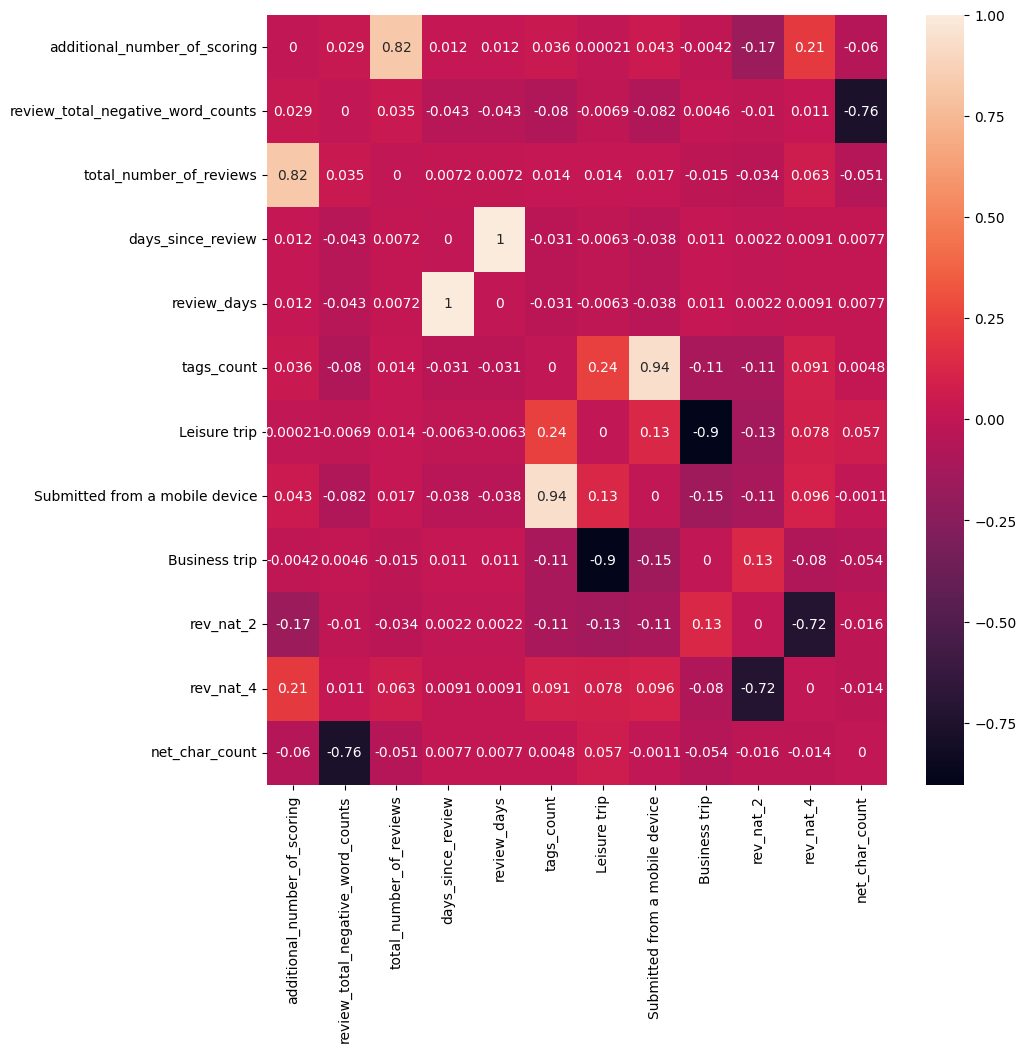

In [134]:
corr_df = data.drop(['sample'], axis=1).corr(numeric_only=True)
np.fill_diagonal(corr_df.to_numpy(), 0)  # заменим диагональные значения с 1 на 0
mask = corr_df[(corr_df > 0.7) | (corr_df < -0.7)].any()  # отберем признаки с корреляцией больше 0.7

fig, ax = plt.subplots(1, figsize=(10, 10))
sns.heatmap(corr_df.loc[mask, mask], annot=True);


* Созданный признак 'review_days' оказался практически идентичным 'days_since_review'. Удаляем его.
* 'tags_count' сильно коррелирует c 'Submitted from a mobile device'. Убираем последний.
* 'Leisure trip' c 'Business trip' (что естественно). Убираем последний.
* Под вопросом оставим коррелирующие 'net_char_count' и 'review_total_negative_word_counts', 'total_number_of_reviews' и 'additional_number_of_scoring'.
* Также пока оставляем 'total_number_of_reviews' с 'additional_number_of_scoring'.

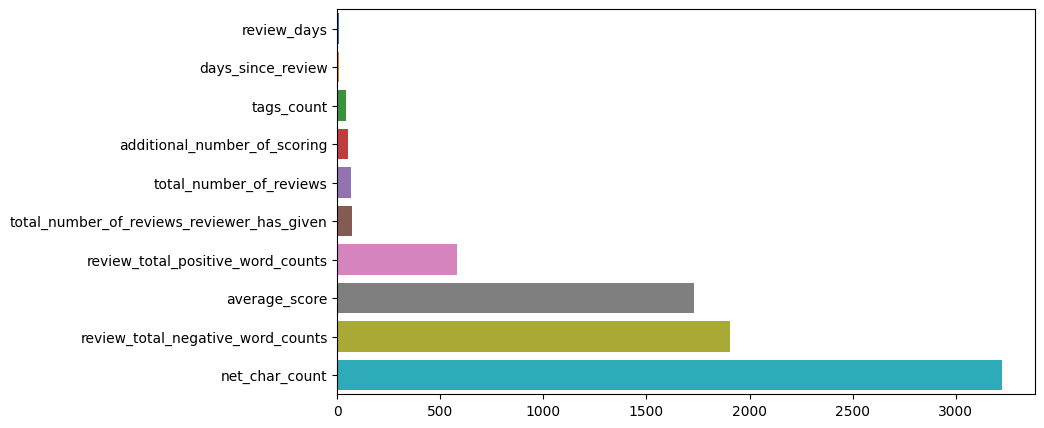

In [135]:
# Для оценки значимости непрерывных используем f_classif из библиотеки sklearn (anova)

from sklearn.feature_selection import f_classif 

imp_num = pd.Series(
    f_classif(data.loc[(data['sample'] == 1), num_cols],
              data.loc[(data['sample'] == 1), 'reviewer_score'])[0], 
    index = num_cols)
imp_num.sort_values(inplace = True)
fig, ax = plt.subplots(1, figsize=(9, 5))
sns.barplot(x=imp_num, y=imp_num.index);


* Признаки 'review_days' и 'days_since_review' имеют наименьшую значимость. Их можно удалить.

In [136]:
data.drop(columns=['review_days', 'Submitted from a mobile device', 'Business trip'], inplace=True)

In [137]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [138]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [139]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

In [140]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [141]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания 
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished


In [142]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test).
# Mean Absolute Error (MAE) среднее отклонение предсказанных значений от фактических.
# Mean Absolute Percentage Error (MAPE) в процентах.
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.889125347397267
MAPE: 0.1281664131270301


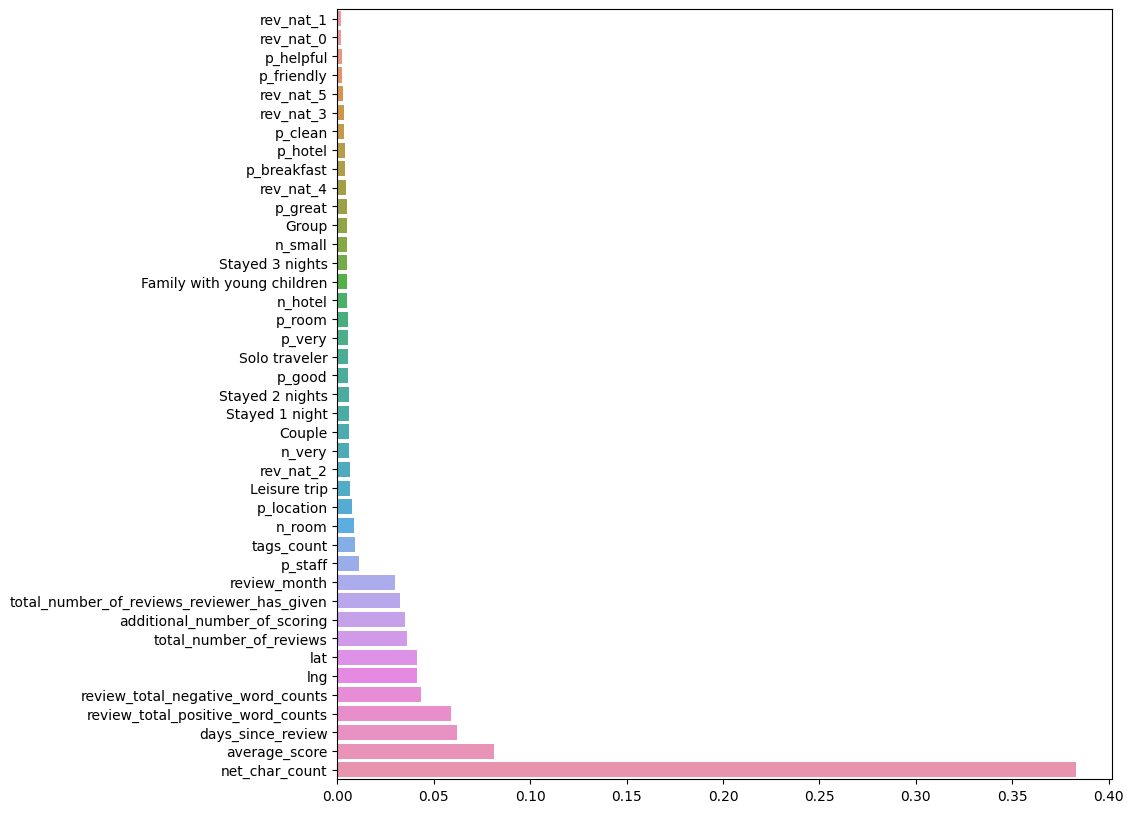

In [143]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

fig, ax = plt.subplots(1, figsize=(10, 10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values()
sns.barplot(y=feat_importances.index, x=feat_importances.values);

In [144]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,p_good,p_helpful,p_friendly,p_great,p_breakfast,p_clean,n_room,n_very,n_hotel,n_small
88346,0.079821,0.565217,0.029412,0.114392,0.065823,0.028249,0.489041,52.337568,4.817817,0.0,...,False,False,False,True,False,True,False,False,False,False
79542,0.063782,0.673913,0.044118,0.064774,0.005063,0.008475,0.943836,48.863979,2.335262,0.0,...,False,False,False,False,False,False,False,False,True,False
37579,0.156658,0.717391,0.053922,0.105792,0.030380,0.141243,0.616438,51.495923,-0.170292,0.0,...,True,False,False,False,True,False,True,True,False,True
82892,0.042521,0.608696,0.019608,0.087388,0.020253,0.022599,0.778082,0.000000,0.000000,0.0,...,True,False,False,False,True,False,False,False,False,False
93475,0.284968,0.695652,0.075980,0.279245,0.022785,0.000000,0.590411,52.372707,4.894366,0.0,...,False,False,False,True,False,False,False,False,False,False
67488,0.108915,0.760870,0.000000,0.112167,0.030380,0.000000,0.401370,41.379921,2.172818,0.0,...,False,True,True,False,False,False,False,False,False,False
67492,0.035808,0.478261,0.036765,0.032056,0.005063,0.028249,0.595890,48.871921,2.297140,0.0,...,False,False,False,False,False,False,True,False,False,False
32799,0.142857,0.869565,0.000000,0.239009,0.681013,0.240113,0.078082,45.482669,9.203437,0.0,...,True,True,True,True,True,False,False,False,False,False
124016,0.107423,0.782609,0.000000,0.177122,0.053165,0.005650,0.500000,41.397623,2.188975,0.0,...,False,True,True,False,False,True,False,False,False,False
66164,0.056695,0.869565,0.000000,0.047633,0.017722,0.000000,0.879452,45.470532,9.193020,0.0,...,False,False,False,False,False,False,False,False,False,False


In [145]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [146]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [147]:
predict_submission_0 = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission_0
sample_submission.to_csv('submission_0.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.8s finished


,reviewer_score,id
0,8.637,488440
1,7.189,274649
2,8.187,374688
3,9.526,404352
4,9.606,451596
5,8.067,302161
6,7.387,317079
7,7.851,13963
8,9.037,159785
9,7.381,195089


#### В качестве альтернативной модели используем XGBRegressor

In [148]:
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5)
my_model_2.fit(X_train, y_train,
             eval_set=[(X_test, y_test)], 
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [149]:
pred_XGBR = my_model_2.predict(X_test)
print('MAE:', mean_absolute_error(pred_XGBR, y_test))
print('MAPE:', mean_absolute_percentage_error(pred_XGBR, y_test))

MAE: 0.8549807454420325
MAPE: 0.10910099013859025


#### XGBRegressor показывает лучший результат, отправляем его на сабмишн.

In [150]:
predict_submission_XGBR = my_model_2.predict(test_data)
sample_submission['reviewer_score'] = predict_submission_XGBR
sample_submission.to_csv('submission_02.csv', index=False)
sample_submission.head(10)


,reviewer_score,id
0,8.907347,488440
1,7.580209,274649
2,8.512728,374688
3,9.636174,404352
4,9.688207,451596
5,8.366701,302161
6,7.982542,317079
7,7.881441,13963
8,9.087155,159785
9,7.390773,195089
